### Take a look at SPY

In [1]:
from dateutil.relativedelta import relativedelta
from datetime import date
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set_style('whitegrid')

In [3]:
# read and plot SPY data

spy = pd.read_csv('../data/SPY.csv', index_col='Date',
                  usecols=['Date', 'Adj Close'], parse_dates=True)
spy.head()

,Adj Close
Date,
2012-09-12,144.39
2012-09-11,143.91
2012-09-10,143.51
2012-09-07,144.33
2012-09-06,143.77


In [4]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3175 entries, 2012-09-12 to 2000-02-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  3175 non-null   float64
dtypes: float64(1)
memory usage: 49.6 KB


In [5]:
spy.describe()

,Adj Close
count,3175.000000
mean,106.953843
std,18.359916
min,63.600000
25%,94.175000
50%,107.250000
75%,121.465000
max,144.390000


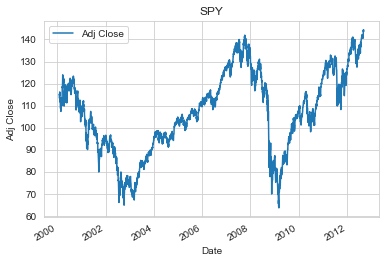

In [19]:
# plot SPY adjusted close
spy.plot()
plt.ylabel('Adj Close')
plt.title('SPY');

### Working with multiple stocks

In [8]:
def get_data(symbols, dates):
    '''
    Returns dataframe with adjusted closing values of the stocks specified in symbols within given time window

    Parameters:
    symbols (list): list of strings containing stock symbols
    dates (datetimes): datetimes within a range

    Returns:
    df (dataframe): dataframe with adjusted closing values of the stocks within specified time window
    '''

    df = pd.DataFrame(index=dates)

    # Add SPY to list of symbols if not already present. It is used as the benchmark.
    if 'SPY' not in symbols:
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_stock = pd.read_csv('../data/{}.csv'.format(symbol), index_col='Date',
                               usecols=['Date', 'Adj Close'], parse_dates=True)
        df_stock.rename(columns={'Adj Close': symbol}, inplace=True)
        df = df.join(df_stock)

    df.dropna(subset=['SPY'], inplace=True)

    return df

In [9]:
def plot_data(df):
    '''
    Plots dataframe df's values

    Parameters:
    None

    Returns:
    None
    '''
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.title('Adj Close vs Date')

In [10]:
def normalize(df):
    '''
    Returns normalized dataframe

    Parameters:
    df (dataframe): dataframe

    Returns:
    (dataframe): normalized dataframe
    '''
    return df / df.iloc[0]

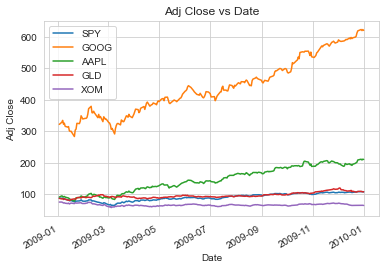

In [16]:
symbols = ['GOOG', 'AAPL', 'GLD', 'XOM']
start_date = pd.to_datetime('2009-01-01')
end_date = pd.to_datetime('2010-01-01')
dates = pd.date_range(start_date, end_date)

df = get_data(symbols, dates)
plot_data(df)

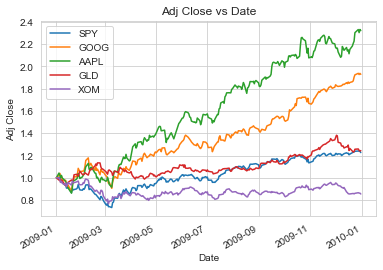

In [18]:
# look at normalized data
df_normalized = normalize(df)
plot_data(df_normalized)

### Bollinger bands

In [20]:
def get_rolling_mean(series, window=20):
    '''
    Return rolling mean of given values, using specified window size.

    Parameters:
    series (series): stock price
    window (int): window for rolling data

    Returns:
    (series): rolling mean
    '''
    return series.rolling(window).mean()


def get_rolling_std(series, window=20):
    '''
    Return rolling standard deviation of given values, using specified window size.

    Parameters:
    series (series): stock price
    window (int): window for rolling data

    Returns:
    (series): rolling standard deviation
    '''
    return series.rolling(window).std()


def get_bollinger_bands(series, window=20):
    '''
    Return upper and lower Bollinger Bands.

    Parameters:
    series (series): stock price
    window (int): window for rolling data

    Returns:
    upper_band (series): upper bollinger band
    lower_band (series): lower bollinger band
    '''
    rolling_mean = get_rolling_mean(series, window)
    rolling_std = get_rolling_std(series, window)
    lower_band = rolling_mean - 2 * rolling_std
    upper_band = rolling_mean + 2 * rolling_std
    return upper_band, lower_band


def plot_bollinger_bands(symbol, window=20, df=df):
    '''
    Plots stock price, rolling mean and Bollinger Bands for given symbol using window provided

    Parameters:
    symbol (str): stock symbol
    window (int): window for rolling data
    df (dataframe): dataframe containing stock price data

    Returns:
    None
    '''
    ax = df[symbol].plot()
    upper_band, lower_band = get_bollinger_bands(df[symbol], window)
    upper_band.plot(color='orange', ax=ax)
    lower_band.plot(color='orange', ax=ax)
    get_rolling_mean(df[symbol], window).plot(color='orange', ls=':', ax=ax)
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.title('Adj Close vs Date for {}'.format(symbol))

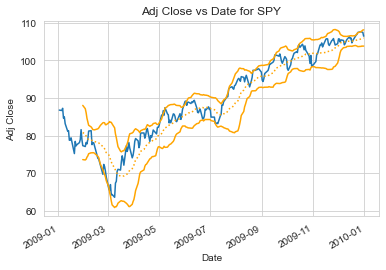

In [21]:
plot_bollinger_bands('SPY')

### Daily and cumulative returns

In [22]:
def compute_daily_returns(df):
    '''
    Compute and return the daily returns.

    Parameters:
    df (dataframe): dataframe containing stock price data

    Returns:
    daily_returns (dataframe): daily returns of the stock prices in dataframe df
    '''
    daily_returns = df.copy()
    daily_returns[1:] = (daily_returns[1:] / daily_returns[:-1].values) - 1
    daily_returns.iloc[0, :] = 0
    return daily_returns


def compute_cumulative_return(df):
    '''
    Compute and return the cumulative return values.

    Parameters:
    df (dataframe): dataframe containing stock price data

    Returns:
    cumulative_returns (dataframe): cumulative returns of the stock prices in dataframe df
    '''
    cumulative_returns = df.iloc[-1] / df.iloc[0] - 1
    return cumulative_returns


def plot_daily_return(symbol, df=df):
    '''
    Plot daily returns.

    Parameters:
    symbol (str): stock symbol
    df (dataframe): dataframe containing stock price data

    Returns:
    None
    '''

    daily_returns = compute_daily_returns(df[symbol])
    daily_returns.plot()
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Daily Returns for {}'.format(symbol))
    plt.axhline(daily_returns.mean(), color='orange', ls='-', lw=2)
    plt.axhline(daily_returns.std(), color='orange', ls='--', lw=2)
    plt.axhline(-daily_returns.std(), color='orange', ls='--', lw=2)

    print(f'Kurtosis: {daily_returns.kurtosis()}')


def plot_daily_return_hist(symbol, bins=20, df=df):
    '''
    Plot daily returns histogram.

    Parameters:
    symbol (str): stock symbol
    bins (int): number of histogram bins
    df (dataframe): dataframe containing stock price data

    Returns:
    None
    '''
    daily_returns = compute_daily_returns(df[symbol])
    daily_returns.hist(bins=bins)
    plt.xlabel('Daily Return')
    plt.title('Daily Returns for {} histogram'.format(symbol))
    plt.axvline(daily_returns.mean(), color='orange', ls='-', lw=2)
    plt.axvline(daily_returns.std(), color='orange', ls='--', lw=2)
    plt.axvline(-daily_returns.std(), color='orange', ls='--', lw=2)

    print(f'Kurtosis: {daily_returns.kurtosis()}')

In [23]:
# Cumulative return for all stocks in the dataframe df
compute_cumulative_return(df)

SPY     0.226613
GOOG    0.929478
AAPL    1.322156
GLD     0.244462
XOM    -0.145408
dtype: float64

Kurtosis: 2.1663392069299734


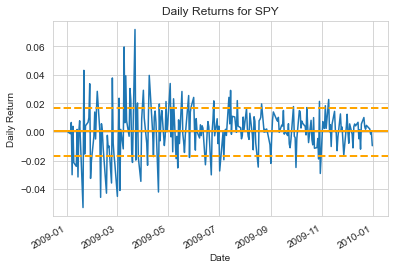

In [24]:
# Plot daily returns for SPY
plot_daily_return('SPY')

Kurtosis: 2.1663392069299734


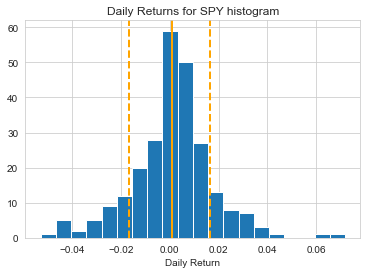

In [25]:
# Plot daily returns for SPY histogram
plot_daily_return_hist('SPY')

Text(0.5, 1.0, 'Pair plot of daily returns')

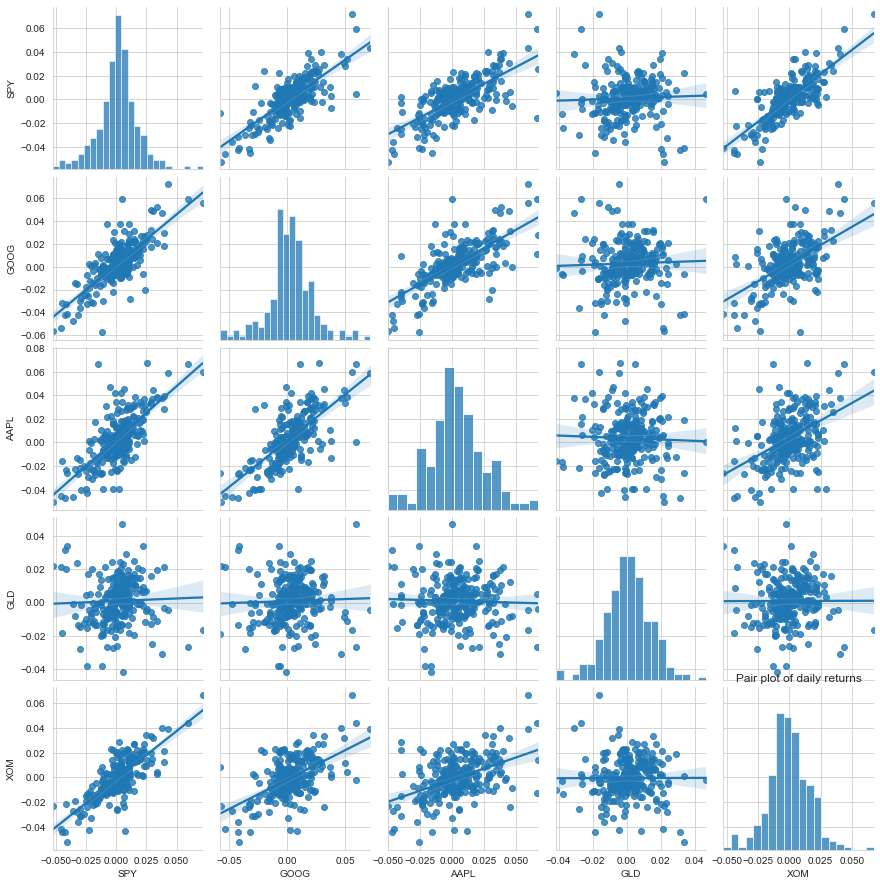

In [26]:
# Pair plot of daily returns
sns.pairplot(compute_daily_returns(df), kind='reg')
plt.title('Pair plot of daily returns')

In [27]:
# Compare 'GOOG' performance to 'SPY'
daily_returns = compute_daily_returns(df)
beta_GOOG, alpha_GOOG = np.polyfit(
    daily_returns['SPY'], daily_returns['GOOG'], 1)
print(f'Beta: {beta_GOOG}, Alpha: {alpha_GOOG}')

Beta: 0.8749683488260136, Alpha: 0.001957537579405948


### Portfolio statistics

In [28]:
# Set up portfolio
companies = ['GOOG','AAPL','GLD','XOM']
allocation = [0.25, 0.25, 0.25, 0.25]
stock_prices = df[companies]
norm_stock_prices = normalize(stock_prices)
allocated_stock_prices = norm_stock_prices * allocation

In [29]:
# Returns for an investment made
investment = 1000
investment_stock_prices = allocated_stock_prices * investment

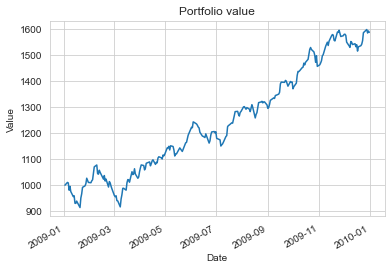

In [30]:
# Portfolio value over time plot
portfolio_value = investment_stock_prices.sum(axis=1)
portfolio_value.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio value');

In [31]:
# Portfolio stats
portfolio_daily_rets = compute_daily_returns(portfolio_value).iloc[1:]
portfolio_cum_rets = compute_cumulative_return(portfolio_value)
avg_daily_ret = portfolio_daily_rets.mean()
std_daily_ret = portfolio_daily_rets.std()

risk_free_return_rate = 0.0002
K = np.sqrt(252)
sharpe_ratio = K * ((portfolio_daily_rets - risk_free_return_rate).mean() /
                    (portfolio_daily_rets - risk_free_return_rate).std())

In [32]:
print(f'Cumulative return: {portfolio_cum_rets:.4f}')
print(f'Average daily return: {avg_daily_ret:.4f}')
print(f'Standard deviation daily return: {std_daily_ret:.4f}')
print(f'Sharpe ratio: {sharpe_ratio:.4f}')

Cumulative return: 0.5877
Average daily return: 0.0019
Standard deviation daily return: 0.0127
Sharpe ratio: 2.1526


### Optimizing portfolio allocation

The goal here is to find the best allocation of stocks in the portfolio to maximize the Sharpe ratio.

In [33]:
# Portfolio setup
companies = ['GOOG','AAPL','GLD','XOM']
init_guess = np.ones(4) * (1 / len(companies))  # equal inital allocation for all stocks
stock_prices = df[companies]
norm_stock_prices = normalize(stock_prices)

In [34]:
def cumulative_return(allocation, norm_stock_prices=norm_stock_prices):
    '''
    Returns negative value of the cumulative return of the portfolio

    Parameters:
    allocation (list): investment allocation
    norm_stock_prices (dataframe): normalized portfolio stock prices

    Returns:
    (float): negative portfolio cumulative return
    '''
    allocated_stock_prices = norm_stock_prices * allocation
    portfolio_value = allocated_stock_prices.sum(axis=1)

    portfolio_cum_rets = compute_cumulative_return(portfolio_value)

    return -portfolio_cum_rets

In [35]:
def sharpe_ratio(allocation, norm_stock_prices=norm_stock_prices, risk_free_return_rate=0.0002):
    '''
    Returns negative value of the sharpe ratio of the portfolio

    Parameters:
    allocation (list): investment allocation
    norm_stock_prices (dataframe): normalized portfolio stock prices
    risk_free_return_rate (float): risk free return rate

    Returns:
    (float): negative portfolio sharpe ratio
    '''
    allocated_stock_prices = norm_stock_prices * allocation
    portfolio_value = allocated_stock_prices.sum(axis=1)

    portfolio_daily_rets = compute_daily_returns(portfolio_value).iloc[1:]
    K = np.sqrt(252)
    sharpe_ratio = K * ((portfolio_daily_rets - risk_free_return_rate).mean() /
                        (portfolio_daily_rets - risk_free_return_rate).std())

    return -sharpe_ratio

In [36]:
# Bounds for allocation of each stock [0.0, 1.0]
bnds = []

for i in range(len(init_guess)):
    bnds.append((0.0, 1.0))

In [37]:
# Find optimal allocation to yield best portfolio sharpe ratio
import scipy.optimize as spo

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # equality constraint for sum of allocations to be 1
bnds = tuple(bnds) # bounds
result = spo.minimize(sharpe_ratio, init_guess, method='SLSQP',
                      constraints=cons, bounds=bnds, options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.773290143967372
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


In [38]:
print(f'Optimal allocation for best portfolio sharpe ratio: {result.x}')

Optimal allocation for best portfolio sharpe ratio: [1.66913416e-01 4.44957551e-01 3.88129033e-01 1.21376433e-16]


In [ ]:
# Set up portfolio with allocation for optimal sharpe ratio
allocation = result.x
stock_prices = df[companies]
norm_stock_prices = normalize(stock_prices)
allocated_stock_prices = norm_stock_prices * allocation

In [ ]:
# Returns for an investment made
investment = 1000
investment_stock_prices = allocated_stock_prices * investment